## Image Segmentation with K-Means Clustering

Image segmentation is the process of dividing an image into parts. Later, the relevant parts of the image can be further processed instead of the whole image, e.g. background-foreground separation, locating objects in images. Segmentation is done by assigning labels to each pixel in the image, pixels sharing some characteristics are labeled similarly.

In [1]:
# import required libraries

import cv2
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer

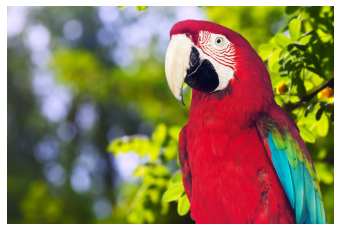

In [2]:
img = mpimg.imread("parrot.jpg")
plt.axis("off")
plt.imshow(img)
plt.show()

We will flatten the image. Each of the pixels in the image will be a data point and each of the RGB channels will be a feature of the point.

In [3]:
data = img.reshape(-1, 3)

Different values of `k` wil result in different segmentations of the image. We will set it to `k=4`.

In [4]:
k = 4
cls = KMeans(
    n_clusters=k
)  # initialize the clustering algorithm with the number of clusters
cls.fit(data)  # decides which cluster each data point belongs to

KMeans(n_clusters=4)

The `labels_` attribute of the clustering object, contains the cluster assignments. We will reshape these cluster assignments to the shape of the original image (excluding the RGB channels) to plot the resulting clustering.

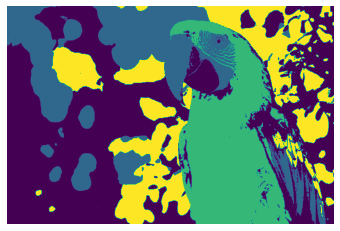

In [5]:
pixel_labels = cls.labels_.reshape(img.shape[:2])
plt.axis("off")
plt.imshow(pixel_labels)
plt.show()

## US State Flora Similarity using Hierarchical Clustering

Another approach to clustering is a bottom-up agglomerative approach. We will use this approach to build a hierarchical clustering method on the [UCI Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Plants). We want to understand if geographically close states have similar flora. 

The data set has 34,782 plant types and their habitat information. In particular, the data set lists the states in US and Canada each plant occurs in. We read in the data set which is in text format, each line contains information for a plant. The raw text is split on the newlines to start preparing for the clustering algorithm. First 5 lines are shown below.

In [6]:
encoding = "ISO-8859-1"  # encoding needed to read the data set properly
with open("plants.data", "rb") as f:
    raw = f.read()

raw = raw.decode(encoding).split(
    "\n"
)  # turn the data set into a list where each list item is a plant
raw[:5]

['abelia,fl,nc',
 'abelia x grandiflora,fl,nc',
 'abelmoschus,ct,dc,fl,hi,il,ky,la,md,mi,ms,nc,sc,va,pr,vi',
 'abelmoschus esculentus,ct,dc,fl,il,ky,la,md,mi,ms,nc,sc,va,pr,vi',
 'abelmoschus moschatus,hi,pr']

As can be seen from above, each line is a comma-separated text. The first field contains the plant name, the rest contains the list of states this plant occurs in. We further split each line on the comma and extract the plant names and features into separate lists.

In [7]:
names = [x.split(",")[0] for x in raw]
features = [x.split(",")[1:] for x in raw]

We need a list of US states to extract data relevant to US states from the plants data set. This information is available in [the states cartographic boundary shape file ](https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip) which is already provided in the homework bundle. More information is available [here](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html). 

This file provides state names as well as coordinate information for plotting purposes. We will use the `states` dataframe that stores this information later for projecting the clustering results on the map.

In [8]:
states = gpd.read_file(
    "cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
)  # read the shape file
# convert the state names to lowercase for compatibility with the plants data set
us_states = states.STUSPS.str.lower().values

At this point, our data is kept in `features` variable which is a list of lists. Scikit-learn provides `MultiLabelBinarizer` class to convert such data sets to vectors which can be used by the machine learning 
algorithms. Documentation of  [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) provides examples on how it works.

Resulting data matrix will have plants on the rows as data points and states as features. However, we would like to see the states' flora similarity. We will transpose the matrix to put our data in correct form.

Lastly, we only care about the US states. We extract those states and obtain our final data set for clustering.

In [9]:
lb = MultiLabelBinarizer()  # initialize the preprocessing object
data = lb.fit_transform(features)  # apply the preprocessing transformation
data = (
    data.T
)  # transpose the matrix to have states on the rows and plants on the columns

usa_idx = np.isin(
    lb.classes_, us_states
)  # get the indices of US states in the data set
data_usa = data[usa_idx]  # extract the rows containing US state data
labels = lb.classes_[usa_idx]  # extract the relevant state names

Scipy provides a hierarchical clustering method. We had already imported `import scipy.cluster.hierarchy` as `shc`. `linkage` method performs the clustering and returns the linkage matrix. [method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) parameter describes how the distance between a cluster and a data point should be calculated. `dendrogram` method visualizes the clustering results.

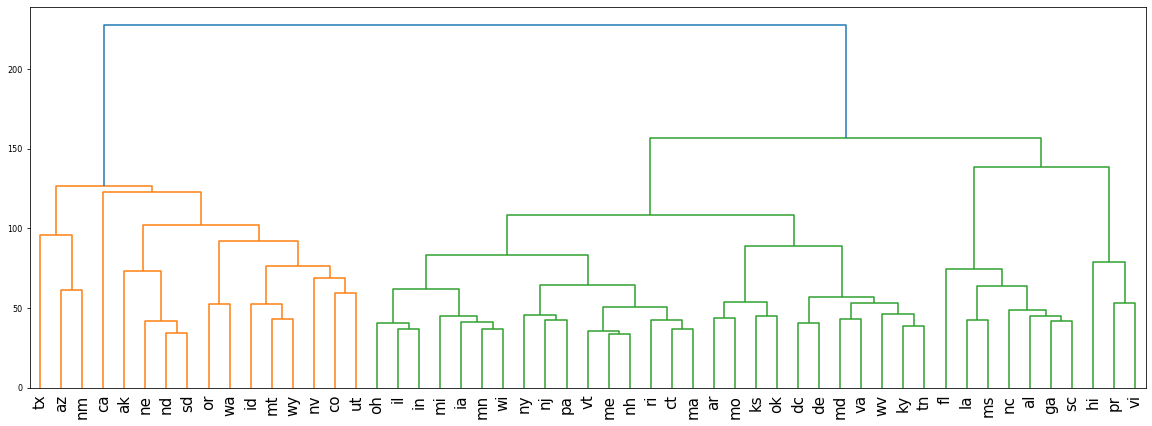

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(1, 1, 1)

Z = shc.linkage(data_usa, method="ward")
shc.dendrogram(Z, labels=labels, ax=ax)

# plotting settings
ax.tick_params(axis="x", which="major", labelsize=15)
ax.tick_params(axis="y", which="major", labelsize=8)

plt.show()
plt.clf()

Lastly, we will project our clustering results on the USA map. You can change the `n_clusters` parameter of the `cut_tree` method to visualize effects of cutting at different tree levels. `cut_tree` returns cluster assignments which we can use to color our USA map. You can vary `n_clusters` in `cut_three` method and see how the state clusters change.

Our data set has flora information for 53 states, we will remove the states with missing flora information from the dataframe used to generate the plot.

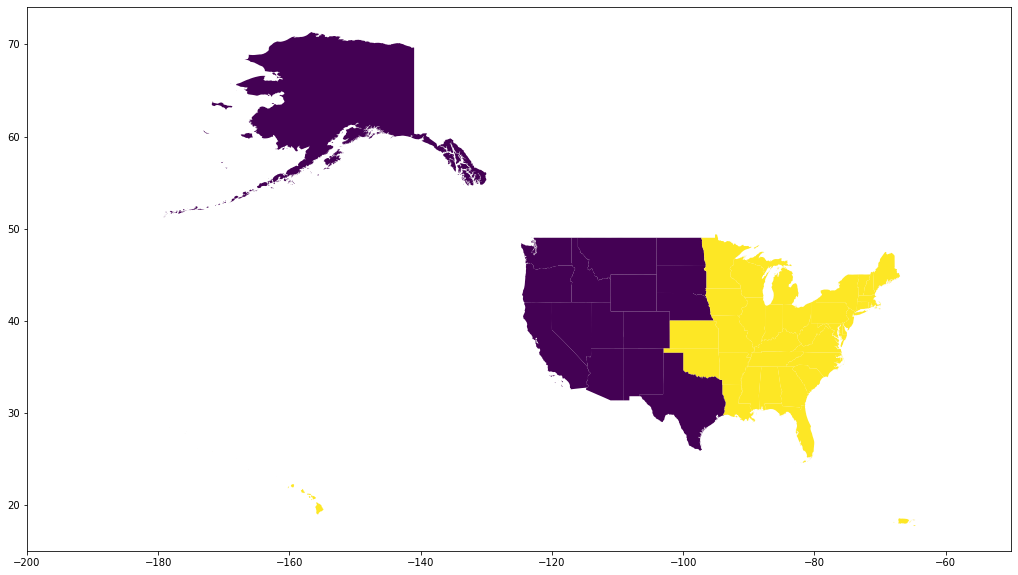

In [11]:
states = states[states.STUSPS.str.lower().isin(labels)]
colors = shc.cut_tree(Z, n_clusters=2).flatten()
color_map = dict(zip(labels, colors))

states["colors"] = [color_map[s.lower()] for s in states.STUSPS]
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
states.plot(column="colors", ax=ax)
plt.xlim([-200, -50])
plt.show()

In [19]:
import Orange


def decompose_dataset(table):
    """Decomposes dataset into attributes and classes"""
    return table.X, table.Y, table.domain.class_var.values


def table2dataframe(table):
    """Converts Orange.Table to pandas.DataFrame"""
    def map_values(vals, real):
        return [real[i] for i in vals]

    attributes = [attr.name for attr in table.domain.attributes]
    target = table.domain.class_var.name

    X, y, _ = decompose_dataset(table)

    return table, pd.DataFrame(data=np.c_[X, y], columns=attributes + [target])


table, _ = table2dataframe(Orange.data.Table("iris"))
table[1,:]

[[4.9, 3.0, 1.4, 0.2 | Iris-setosa]
]

## Exercise

Pick a data set from the UCI repository. 

1. Visualize the data set with t-SNE. 
2. Apply k-means clustering. Vary `k` and comment on the results.

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
tsne_results = tsne.fit_transform(data_usa)

<AxesSubplot:xlabel='Dim 1', ylabel='Dim 2'>

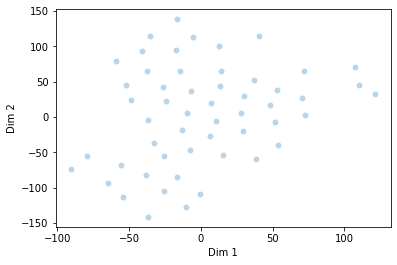

In [13]:
import seaborn as sns

df = pd.DataFrame()
df['Dim 1'] = tsne_results[:,0]
df['Dim 2'] = tsne_results[:,1]

sns.scatterplot(
    x="Dim 1", y="Dim 2",
    # hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3,
)

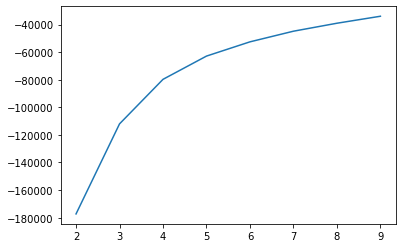

In [36]:
n_clusters = range(2,10)
scores = []
for k in n_clusters:
    cls = KMeans(
        n_clusters=k
    )  # initialize the clustering algorithm with the number of clusters
    cls.fit(df)  # decides which cluster each data point belongs to
    scores.append(cls.score(df))

plt.plot(n_clusters, scores)

We see that as $k$ increases, the score increases. Plateauing occurs at around $k=5$ or $6$.

<AxesSubplot:xlabel='Dim 1', ylabel='Dim 2'>

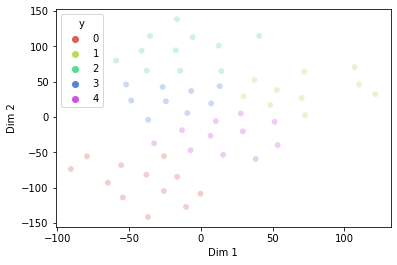

In [39]:
k_chosen = 5
cls = KMeans(n_clusters=k_chosen)
cls.fit(df)
df['y'] = cls.predict(df)

sns.scatterplot(
    x="Dim 1", y="Dim 2",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3,
)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Please contact Zeynep Hakguder (<a href="mailto:zphakguder@gmail.com">zphakguder@gmail.com</a>) for further questions or inquries.